## Cape Town Centrality Analysis using Cityseer

In [1]:
# load packages for analysis
import os
import ast
from cityseer.metrics import networks
from cityseer.tools import graphs, io
import contextily as ctx
import dask.dataframe as dd
import dask_geopandas as dg
import fiona
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import numpy as np
import networkx as nx
import osmnx as ox
import pandas as pd
import pyogrio
import seaborn as sns
from xml import etree
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.preprocessing import StandardScaler
from shapely.geometry import Point
from shapely.geometry import LineString, MultiLineString
import shapely.wkt
import statsmodels.api as sm

### 1. Get Cape Town Street Network from OSM and simplify
The following code uses a bounding box to create a graph of the CPT street network. It then simplifies the nodes and edges

In [2]:
bbox = (18.307,-34.391,19.019,-33.468)

G = ox.graph.graph_from_bbox(bbox, network_type="drive", simplify=True)

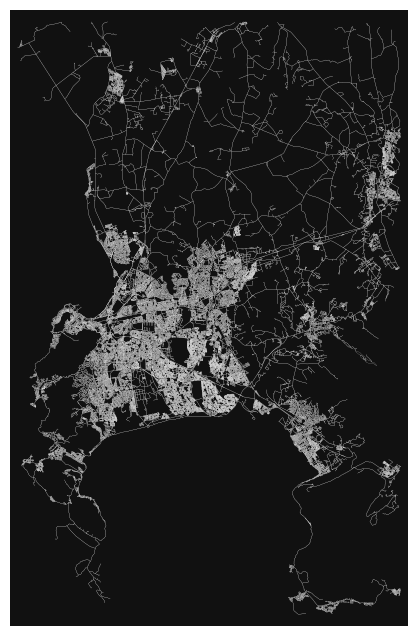

In [3]:
fig, ax = ox.plot.plot_graph(G, node_size=0, edge_color="w", edge_linewidth=0.1)

In [4]:
# get a GeoSeries of consolidated intersections
G = ox.projection.project_graph(G)
ints = ox.simplification.consolidate_intersections(
    G, rebuild_graph=False, tolerance=15, dead_ends=True
)
len(ints)

69273

In [5]:
# consolidate intersections and rebuild graph topology
# this reconnects edge geometries to the new consolidated nodes
G2 = ox.simplification.consolidate_intersections(
    G, rebuild_graph=True, tolerance=15, dead_ends=False
)
len(G2)

59332

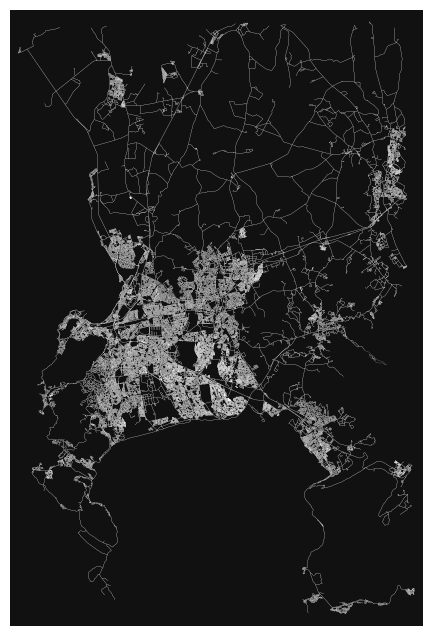

In [6]:
fig, ax = ox.plot.plot_graph(G2, node_size=0, edge_color="w", edge_linewidth=0.1)

#### 1b. Save Cape Town graph as a geopackage

In [11]:
# Assign CRS
G2.graph["crs"] = "EPSG:3857" 

In [13]:
G2.number_of_nodes(), G2.number_of_edges()

(59332, 173270)

In [12]:
# save cpt graph as .gpkg
ox.save_graph_geopackage(G2, "G_ct.gpkg")

INFO:pyogrio._io:Created 59,332 records
INFO:pyogrio._io:Created 92,002 records


### 2. Below, we prepare our Cape Town Graph in order to conduct a centrality assessment using Cityseer
The following section converts G2 into a dual graph to assessed using Cityseer

In [14]:
from cityseer.metrics import networks
from cityseer.tools import graphs, io

In [21]:
# update the file path as needed
cpt_net = gpd.read_file('G_ct.gpkg', layer="edges")

cpt_net.head()

,u,v,key,osmid,highway,lanes,maxspeed,oneway,reversed,length,...,u_original,v_original,from,to,width,bridge,junction,access,tunnel,geometry
0,0,1,0,694334683,primary,2,70,True,False,500.473781,...,26288589,26288274,0,1,,,,,,"LINESTRING (267431.534 6225753.798, 267422.719..."
1,0,2,0,"[30671154, 744678268]",residential,"['2', '3']",60,False,False,82.594912,...,339184127,26288589,2,0,,,,,,"LINESTRING (267349.161 6225747.748, 267369.644..."
2,0,3,1,"[744677555, 744670230]",primary,"['2', '3']",70,True,False,272.372519,...,26288590,26288592,0,3,,,,,,"LINESTRING (267431.534 6225753.798, 267440.348..."
3,0,3,0,"[744670233, 744677554]",primary,2,70,True,False,272.523786,...,26288591,26288589,3,0,,,,,,"LINESTRING (267449.098 6225499.238, 267440.673..."
4,0,4,0,"[744681635, 694334653]",residential,"['2', '3']",50,False,True,389.552458,...,338783934,26288590,4,0,,,,,,"LINESTRING (267820.764 6225753.181, 267761.131..."


#### 2a. Convert CPT graph into its dual representation
In order to use cityseer to calculate centrality, we must convert G2 into a dualgraph.

In [ ]:
print(next(iter(G2.edges(data=True))))

In [ ]:
# Rename 'geometry' to 'geom' for all edges in G2
for u, v, key, data in G2.edges(keys=True, data=True):
    if "geometry" in data:
        data["geom"] = data.pop("geometry")  # Rename the attribute

In [ ]:
print(G2.graph["crs"])  # Check CRS of the graph

In [ ]:
# convert the network to its dual representation
G2 = graphs.nx_to_dual(G2)

# print number of nodes and edges
G2_dual_nx.number_of_nodes(), G2_dual_nx.number_of_edges()